# **IMPORT**

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

ModuleNotFoundError: No module named 'seaborn'

# **ĐỌC DỮ LIỆU**

In [ ]:
def load_data(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    X = []
    y = []

    for sample in data:
        embedding = np.array(sample['audio_embedding'])  # shape: (n_frames, 128)
        # Sử dụng mean vector cho mỗi sample (n_frames -> 1 vector)
        mean_vec = np.mean(embedding, axis=0)
        X.append(mean_vec)
        y.append(sample['is_turkey'])

    return np.array(X), np.array(y)

X, y = load_data('../Data/train.json')  # Cập nhật đường dẫn nếu cần

df = pd.DataFrame(X)
df['is_turkey'] = y
df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,is_turkey
0,166.6,29.3,198.4,106.4,215.2,57.5,77.3,65.0,188.5,149.7,...,85.2,44.3,186.2,0.0,48.2,238.6,138.5,101.0,255.0,0
1,173.3,13.7,164.7,93.5,201.3,94.2,122.0,114.0,166.0,181.8,...,29.1,77.2,150.2,48.1,126.1,231.3,35.9,14.9,255.0,1
2,156.2,14.7,152.0,80.0,221.6,60.8,113.8,80.9,170.8,189.5,...,140.5,52.7,167.7,1.0,93.9,201.5,189.3,77.5,255.0,1
3,152.3,8.9,154.9,79.2,211.0,68.7,99.2,97.2,178.2,201.6,...,232.6,112.7,71.4,46.5,79.3,133.6,64.0,59.1,255.0,1
4,156.5,12.5,185.8,98.4,214.2,85.9,86.2,79.1,169.7,183.9,...,213.3,128.2,182.5,21.8,52.1,223.1,110.5,33.9,255.0,0


# **CHIA DỮ LIỆU THÀNH CÁC TẬP TRAIN/VALID/TEST**

In [ ]:
# Chia train+val và test trước
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
# Chia tiếp train và val từ X_temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)
# 0.85 * 0.1765 ≈ 0.15, nên tỉ lệ cuối cùng là 70% train, 15% val, 15% test
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 835, Val: 180, Test: 180


# **HUẤN LUYỆN MÔ HÌNH**

In [ ]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "model__C": [0.01, 0.1, 1, 10],
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [20, 100],
            "model__max_depth": [None, 10, 20]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "model__C": [0.01, 1, 10],
            "model__kernel": ["linear", "rbf"]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.01, 0.1, 0.2]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ["uniform", "distance"]
        }
    }
}

In [ ]:
results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, mp in models.items():
    print(f"\nTuning model: {name}")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp['model'])
    ])
    clf = GridSearchCV(pipe, mp['params'], cv=cv, scoring='f1', n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # Dự đoán trên val
    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_proba)
    f1 = classification_report(y_val, y_pred, output_dict=True)['weighted avg']['f1-score']

    results[name] = {
        'model': clf.best_estimator_,
        'best_params': clf.best_params_,
        'accuracy': acc,
        'roc_auc': roc,
        'f1_score': f1,
        'y_true': y_val,   # thêm y_true vào đây
        'y_pred': y_pred   # thêm y_pred vào đây
    }

    print("Best params:", clf.best_params_)
    print("Accuracy:", acc)
    print("ROC AUC:", roc)
    print("F1 Score:", f1)


Tuning model: LogisticRegression


Best params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Accuracy: 0.9611111111111111
ROC AUC: 0.9883987761346251
F1 Score: 0.9608792641050706

Tuning model: RandomForest
Best params: {'model__max_depth': None, 'model__n_estimators': 100}
Accuracy: 0.95
ROC AUC: 0.9871876593574708
F1 Score: 0.9498315958299919

Tuning model: SVM
Best params: {'model__C': 1, 'model__kernel': 'rbf'}
Accuracy: 0.9611111111111111
ROC AUC: 0.9867414584395717
F1 Score: 0.9608792641050706

Tuning model: GradientBoosting
Best params: {'model__learning_rate': 0.2, 'model__n_estimators': 50}
Accuracy: 0.9444444444444444
ROC AUC: 0.9839367669556349
F1 Score: 0.9444444444444444

Tuning model: KNN
Best params: {'model__n_neighbors': 7, 'model__weights': 'uniform'}
Accuracy: 0.9444444444444444
ROC AUC: 0.9866777154513002
F1 Score: 0.9440352615181404


In [ ]:
data = []
for model_name, metrics in results.items():
    row = {'Model': model_name}
    row.update(metrics)
    data.append(row)

# Tạo DataFrame
df_results = pd.DataFrame(data)
df_results = df_results.round(4)
df_results

,Model,model,best_params,accuracy,roc_auc,f1_score,y_true,y_pred
0,LogisticRegression,"(StandardScaler(), LogisticRegression(C=0.01, ...","{'model__C': 0.01, 'model__penalty': 'l2', 'mo...",0.9611,0.9884,0.9609,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,RandomForest,"(StandardScaler(), (DecisionTreeClassifier(max...","{'model__max_depth': None, 'model__n_estimator...",0.9500,0.9872,0.9498,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
2,SVM,"(StandardScaler(), SVC(C=1, probability=True))","{'model__C': 1, 'model__kernel': 'rbf'}",0.9611,0.9867,0.9609,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,GradientBoosting,"(StandardScaler(), ([DecisionTreeRegressor(cri...","{'model__learning_rate': 0.2, 'model__n_estima...",0.9444,0.9839,0.9444,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,KNN,"(StandardScaler(), KNeighborsClassifier(n_neig...","{'model__n_neighbors': 7, 'model__weights': 'u...",0.9444,0.9867,0.9440,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


<Figure size 400x400 with 0 Axes>

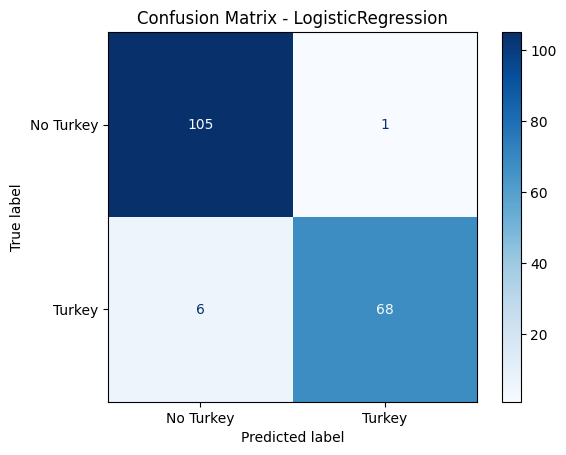

<Figure size 400x400 with 0 Axes>

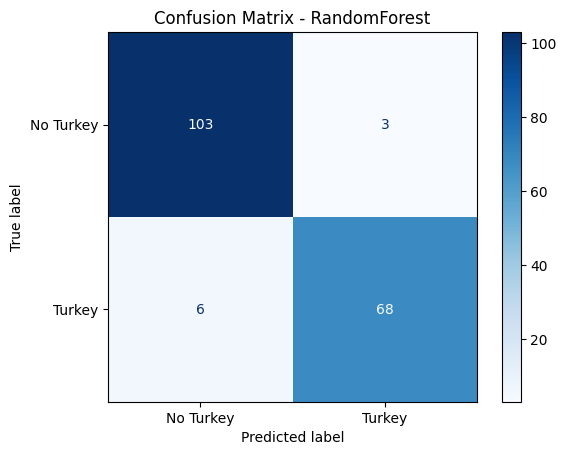

<Figure size 400x400 with 0 Axes>

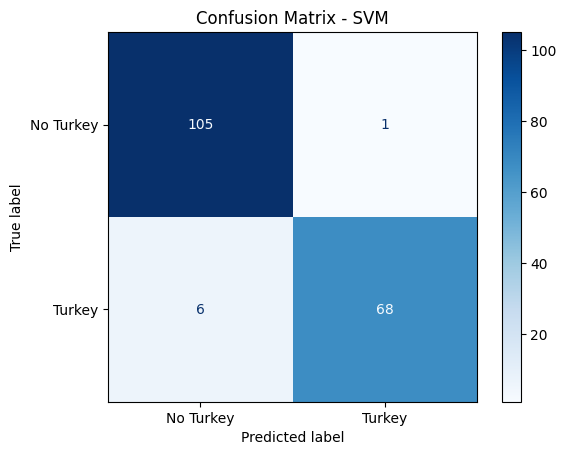

<Figure size 400x400 with 0 Axes>

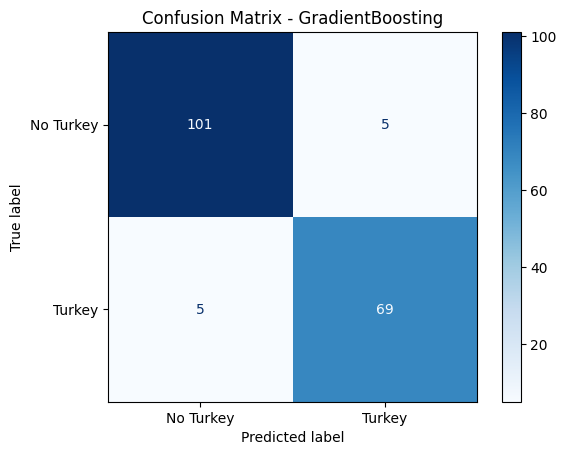

<Figure size 400x400 with 0 Axes>

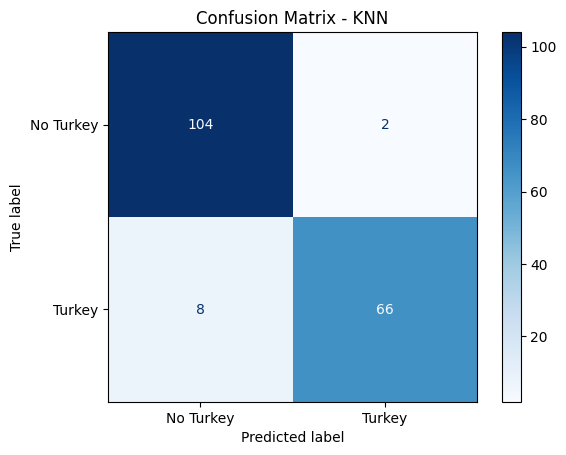

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, res in results.items():
    y_val = res['y_true']     # Ground truth
    y_val_pred = res['y_pred']     # Predicted labels

    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Turkey", "Turkey"])

    plt.figure(figsize=(4, 4))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [ ]:
# best_model = results['LogisticRegression']['model']
# best_model

In [ ]:
# Gộp train và val
X_full = np.concatenate([X_train, X_val], axis=0)
y_full = np.concatenate([y_train, y_val], axis=0)

In [ ]:
# Lấy best_params từ GridSearchCV
best_params_lr = results['LogisticRegression']['best_params']

# Tạo lại pipeline với best_params
final_model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, **{k.replace('model__', ''): v for k, v in best_params_lr.items()}))
])
final_model_lr.fit(X_full, y_full)

# Đánh giá trên test
y_test_pred = final_model_lr.predict(X_test)
y_test_proba = final_model_lr.predict_proba(X_test)[:, 1]
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1:")
print(classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))

Test Accuracy: 0.9611111111111111
Test F1:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       106
           1       0.96      0.95      0.95        74

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180

Test ROC AUC: 0.9917134115247324


In [ ]:
# Lấy best_params từ GridSearchCV
best_params_svm = results['SVM']['best_params']

# Tạo lại pipeline với best_params
final_model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(probability=True, **{k.replace('model__', ''): v for k, v in best_params_svm.items()}))
])
final_model_svm.fit(X_full, y_full)

# Đánh giá trên test
y_test_pred = final_model_svm.predict(X_test)
y_test_proba = final_model_svm.predict_proba(X_test)[:, 1]
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1:")
print(classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))

Test Accuracy: 0.9611111111111111
Test F1:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       106
           1       0.96      0.95      0.95        74

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180

Test ROC AUC: 0.9918408975012749


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

# Lấy best_params từ GridSearchCV
best_params_lr = results['LogisticRegression']['best_params']
best_params_svm = results['SVM']['best_params']

# Lọc tham số cho từng model
lr_params = {k.replace('model__', ''): v for k, v in best_params_lr.items() if k.startswith('model__')}
svm_params = {k.replace('model__', ''): v for k, v in best_params_svm.items() if k.startswith('model__')}

# Khởi tạo mô hình với best_params
clf1 = LogisticRegression(max_iter=1000, **lr_params)
clf2 = SVC(probability=True, **svm_params)

# Tạo pipeline cho mỗi mô hình (nếu cần scaling)
pipe1 = make_pipeline(StandardScaler(), clf1)
pipe2 = make_pipeline(StandardScaler(), clf2)

# VotingClassifier (soft voting dùng xác suất)
ensemble = VotingClassifier(
    estimators=[
        ('lr', pipe1),
        ('svm', pipe2)
    ],
    voting='soft',
    n_jobs=-1
)

# Huấn luyện trên X_full, y_full
ensemble.fit(X_full, y_full)

# Dự đoán trên test
y_test_pred = ensemble.predict(X_test)
y_test_proba = ensemble.predict_proba(X_test)[:, 1]

print("Test Accuracy (ensemble):", accuracy_score(y_test, y_test_pred))
print("Test F1 (ensemble):")
print(classification_report(y_test, y_test_pred))
print("Test ROC AUC (ensemble):", roc_auc_score(y_test, y_test_proba))

Test Accuracy (ensemble): 0.9611111111111111
Test F1 (ensemble):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       106
           1       0.96      0.95      0.95        74

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180

Test ROC AUC (ensemble): 0.9929882712901581


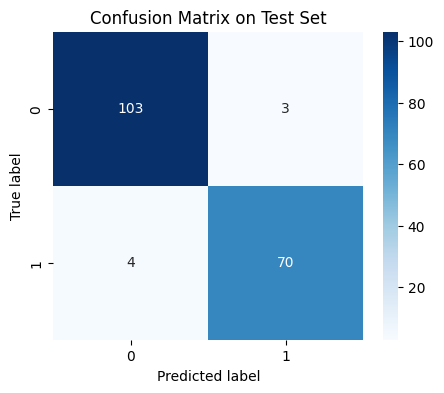

In [ ]:
# Nếu y_test_pred đã là nhãn cứng (0/1), dùng luôn
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
with open('../Data/test.json', 'r') as f:
    test_data = json.load(f)

X_submit = []
vid_ids = []

for sample in test_data:
    embedding = np.array(sample['audio_embedding'])
    mean_vec = np.mean(embedding, axis=0)
    X_submit.append(mean_vec)
    vid_ids.append(sample['vid_id'])

X_submit = np.array(X_submit)

y_submit_proba = ensemble.predict_proba(X_submit)[:, 1]

submission = pd.DataFrame({
    "vid_id": vid_ids,
    "is_turkey": y_submit_proba
})
submission.to_csv("result.csv", index=False)